In [42]:
import numpy as np
import matplotlib.pyplot as plt
import math 
import pandas as pd
from scipy import optimize

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

The function has 2 global minima in (x1,y1)=(-0.090,0.713) and (x2,y2)=(0.090,-0.713) and the value of the function is: -1.03163

When the initial guess is (0,0) the algorithm converges in a local minimum

       fun: 0.0
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 5.96046448e-08, -5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])


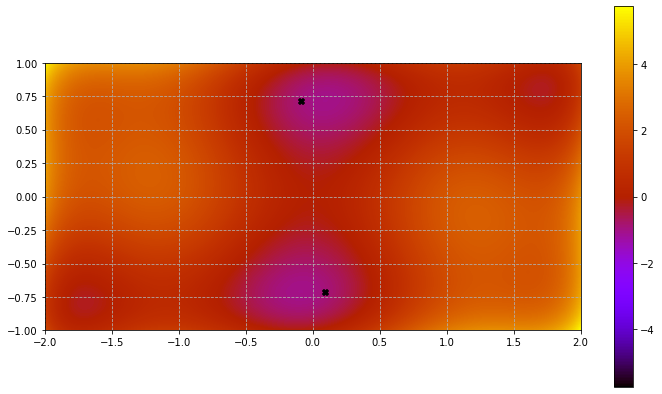

In [43]:
def fun(vec):
    x=vec[0]
    y=vec[1]
    f=(4-2.1*x**2+(x**4)/3)*x**2+x*y+(4*y**2-4)*y**2
    return f


x=np.linspace(-2,2,1000)
y=np.linspace(-1,1,1000)



X,Y=np.meshgrid(x,y)
Z=fun([X,Y])
Zmin, Zmax = -np.abs(Z).max(), np.abs(Z).max()

fig,ax=plt.subplots(figsize=(12,7))

c=ax.imshow(Z, cmap ='gnuplot', vmin = Zmin, vmax = Zmax,
                 extent =[X.min(), X.max(), Y.min(), Y.max()])
plt.colorbar(c)

#1
minim1=optimize.minimize(fun, x0=[0,0.7])
minim2=optimize.minimize(fun, x0=[0,-0.7])
if np.allclose(minim1["fun"], minim2["fun"]):
    print("The function has 2 global minima in (x1,y1)=({:.3f},{:.3f}) and (x2,y2)=({:.3f},{:.3f}) and the value of the function is: {:.5f}\n".format(minim1['x'][0], minim1['x'][1], minim2['x'][0], minim2['x'][1], minim1["fun"]))

print("When the initial guess is (0,0) the algorithm converges in a local minimum")
minim0=optimize.minimize(fun, x0=[0,0])
print("\n",minim0)

ax.scatter(minim1['x'][0], minim1['x'][1], marker="X", c='black')
ax.scatter(minim2['x'][0], minim2['x'][1], marker="X", c='black')
ax.grid(linestyle='--')



2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

For maximum temperatures: 

parameters:
 [-10.58169954   7.01384797  27.94963531   0.09426337]
covariance matrix:
 [[ 1.68164490e-01 -5.22764162e-03 -6.55243782e-03  1.36693502e-04]
 [-5.22764162e-03  2.13583271e-02 -4.20385045e-02 -4.71525076e-04]
 [-6.55243782e-03 -4.20385045e-02  1.83397607e-01  1.01902840e-03]
 [ 1.36693502e-04 -4.71525076e-04  1.01902840e-03  1.13661594e-05]]
a = -10.58 +- 0.41
b = 7.01 +- 0.15
c = 27.95 +- 0.43
For minimum temperatures: 

parameters:
 [-25.1496209  -24.70956931 -36.71257655   1.09570314]
covariance matrix:
 [[ 1.72807386e+00  3.66321320e-03 -1.89178099e-01  3.95281397e-05]
 [ 3.66321320e-03  2.70523705e-02 -1.04191709e-01 -5.66540470e-04]
 [-1.89178099e-01 -1.04191709e-01  1.41861698e+00  2.54658975e-03]
 [ 3.95281397e-05 -5.66540470e-04  2.54658975e-03  1.34433036e-05]]
a = -25.15 +- 1.31
b = -24.71 +- 0.16
c = -36.71 +- 1.19


<ipython-input-52-f46f845cfadb>:13: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(m, months)


TypeError: f() missing 1 required positional argument: 'k'

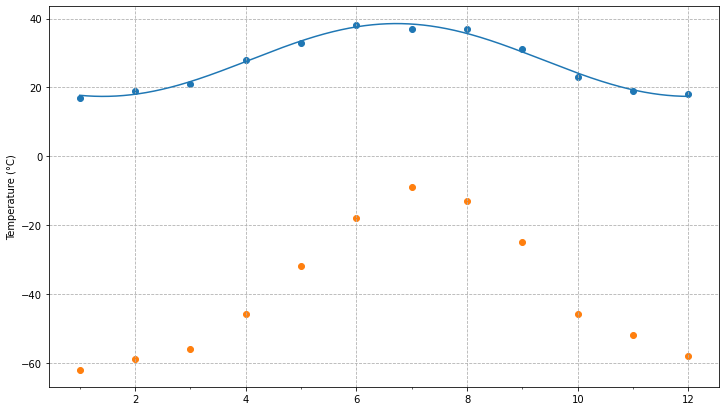

In [52]:
import calendar

months = [x for x in calendar.month_name[1:]]
m=np.arange(1,13,1)
Tmax=[17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18]
Tmin=[-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]

fig, ax=plt.subplots(figsize=(12,7))
ax.grid(linestyle='--')
ax.scatter(m, Tmax)
ax.scatter(m, Tmin)
ax.set_ylabel("Temperature (°C)")
ax.set_xticks(m, months)

def f(x, a, b, c,k):
    f=a*np.sin(2*math.pi*k*x+b)+c
    #f=a*x**2+b*x+c
    return f

print("For maximum temperatures: \n")
Mp, Mpcov = optimize.curve_fit(f, m, Tmax, p0=[10,7,20,1/12])#, full_output=False)
print("parameters:\n", Mp)
print("covariance matrix:\n", Mpcov)
print("a = %.2f +- %.2f" % (Mp[0], np.sqrt(Mpcov[0,0])))
print("b = %.2f +- %.2f" % (Mp[1], np.sqrt(Mpcov[1,1])))
print("c = %.2f +- %.2f" % (Mp[2], np.sqrt(Mpcov[2,2])))

print("For minimum temperatures: \n")
mp, mpcov = optimize.curve_fit(f, m, Tmin)#, full_output=False)
print("parameters:\n", mp)
print("covariance matrix:\n", mpcov)
print("a = %.2f +- %.2f" % (mp[0], np.sqrt(mpcov[0,0])))
print("b = %.2f +- %.2f" % (mp[1], np.sqrt(mpcov[1,1])))
print("c = %.2f +- %.2f" % (mp[2], np.sqrt(mpcov[2,2])))

X=np.linspace(1,12,1000)
ax.plot(X,f(X, Mp[0], Mp[1], Mp[2], Mp[3]))
ax.plot(X,f(X, mp[0], mp[1], mp[2]))

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.